In [133]:
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import matplotlib as mpl
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf
import selfies as sf
import exmol
from dataclasses import dataclass
from rdkit.Chem.Draw import rdDepictor
from rdkit.Chem import MolFromSmiles, MACCSkeys
rdDepictor.SetPreferCoordGen(True)
# sns.set_context('notebook')
# sns.set_style('white',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#666666', 'ytick.color': '#666666',
#                         'axes.edgecolor': '#666666', 'axes.linewidth':     0.8 , 'figure.dpi': 300})
color_cycle = ['#1BBC9B', '#F06060', '#5C4B51', '#F3B562', '#6e5687']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_cycle) 
soldata = pd.read_csv('https://github.com/whitead/dmol-book/raw/master/data/curated-solubility-dataset.csv')
features_start_at = list(soldata.columns).index('MolWt')
np.random.seed(0)

In [2]:
# scramble them
# Reduced for CI!
# soldata = soldata.sample(frac=0.01, random_state=0).reset_index(drop=False)
# soldata.head()
soldata = soldata.sample(frac=1, random_state=0).reset_index(drop=False)
len(soldata.SMILES)

9982

In [134]:
selfies_list = [sf.encoder(exmol.sanitize_smiles(s)[1]) for s in soldata.SMILES]
len(selfies_list)

9982

In [135]:
vocab = list(sf.get_alphabet_from_selfies([s for s in selfies_list if s is not None]))
vocab_stoi = {o:i for o,i in zip(vocab, range(len(vocab)))}
print('Vocab size', len(vocab))

def selfies2ints(s):
    result = []
    for token in sf.split_selfies(s):
        if token == '.':
            continue #?
        if token in vocab_stoi:
            result.append(vocab_stoi[token])
        else:
            result.append(np.nan)
            #print('Warning')
    return result
def ints2selfies(v):
    return ''.join([vocab[i] for i in v])

# test them out
s = selfies_list[0]
print('selfies:', s)
v = selfies2ints(s)
print('selfies2ints:', v)
so = ints2selfies(v)
print('ints2selfes:', so)
# assert so == s

Vocab size 206
selfies: [C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][N+expl][Branch1_1][C][C][Branch1_1][C][C][C].[Br-expl]
selfies2ints: [37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 102, 189, 37, 37, 189, 37, 37, 37, 139]
ints2selfes: [C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][N+expl][Branch1_1][C][C][Branch1_1][C][C][C][Br-expl]


In [136]:
#creating an object
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    embedding_dim: int
    rnn_units: int
    hidden_dim: int
        
config = Config(vocab_size=len(vocab), 
                example_number=len(selfies_list), 
                batch_size=16, 
                buffer_size=10000, 
                embedding_dim=256, 
                hidden_dim=128,
                rnn_units=128)

In [137]:
# now get sequences
encoded = [selfies2ints(s) for s in selfies_list if s is not None]
padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(encoded, padding='post')

# Now build dataset
data = tf.data.Dataset.from_tensor_slices((padded_seqs, soldata.Solubility.iloc[[bool(s) for s in selfies_list]].values))
# now split into val, test, train and batch
N = len(data)  
print(N)
split = int(0.1 * N)
test_data = data.take(split).batch(config.batch_size)
nontest = data.skip(split)
val_data, train_data = nontest.take(split).batch(config.batch_size), \
    nontest.skip(split).shuffle(config.buffer_size).batch(config.batch_size).prefetch(tf.data.experimental.AUTOTUNE)

9982


In [14]:
model = tf.keras.Sequential()

# make embedding and indicate that 0 should be treated as padding mask
model.add(tf.keras.layers.Embedding(input_dim=config.vocab_size, output_dim=config.embedding_dim, mask_zero=True))

# RNN layer
model.add(tf.keras.layers.GRU(config.rnn_units))
# a dense hidden layer
model.add(tf.keras.layers.Dense(config.hidden_dim, activation='relu'))
# regression, so no activation
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         52736     
_________________________________________________________________
gru (GRU)                    (None, 128)               148224    
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 217,601
Trainable params: 217,601
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(tf.optimizers.Adam(1e-4), loss='mean_squared_error')
result = model.fit(train_data, validation_data=val_data, epochs=100, verbose=0)

In [138]:
# model.save('solubility-rnn')
model = tf.keras.models.load_model('solubility-rnn/')
# result = model.fit(train_data, validation_data=val_data, epochs=100, verbose=0)

😀Calling your model function😀: : 5000it [07:10, 11.62it/s]  


In [8]:
plt.plot(result.history['loss'], label='training')
plt.plot(result.history['val_loss'], label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

NameError: name 'result' is not defined

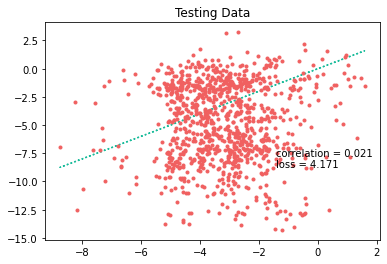

In [139]:
yhat = []
test_y = []
for x,y in test_data:
    yhat.extend(model(x).numpy().flatten())
    test_y.extend(y.numpy().flatten())
yhat = np.array(yhat)
test_y = np.array(test_y)

# plot test data
plt.plot(test_y, test_y, ':')
plt.plot(test_y, yhat, '.')
plt.text(max(test_y) - 3, min(test_y) + 1, f'correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}')
plt.text(max(test_y) - 3, min(test_y), f'loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}')
plt.title('Testing Data')
plt.savefig('rnn-fit.png', dpi=300)
plt.show()


## CF explanation:

In the following example let's say we would like our molecules to return a solubility value of -3.5. Here we use `counterstone` algorithm to create counter factual explanations. In other words, we would like to see what are the minimal mutations that could to be done to our input structure to get our desired solubility.

In [140]:
def predictor_function(smile_list,selfies):
    encoded = [selfies2ints(s) for s in selfies]
    # check for nans
    valid = [1. if sum(e) > 0 else np.nan for e in encoded]
    encoded = [np.nan_to_num(e, nan=0) for e in encoded]
    padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(encoded, padding='post')
    labels = np.reshape(model.predict(padded_seqs), (-1))
    return labels * valid

In [141]:
predictor_function([], ['[C][#S-expl]', '[C]'])

array([        nan, -0.41368222])

In [145]:
stoned_kwargs={'num_samples': 2500, 'alphabet':exmol.get_basic_alphabet(), 'max_mutations': 2}
space = exmol.sample_space(soldata.SMILES[1000], predictor_function, stoned_kwargs=stoned_kwargs)

🤘Done🤘: 100%|██████████| 1701.0/1701 [00:03<00:00, 494.69it/s]              


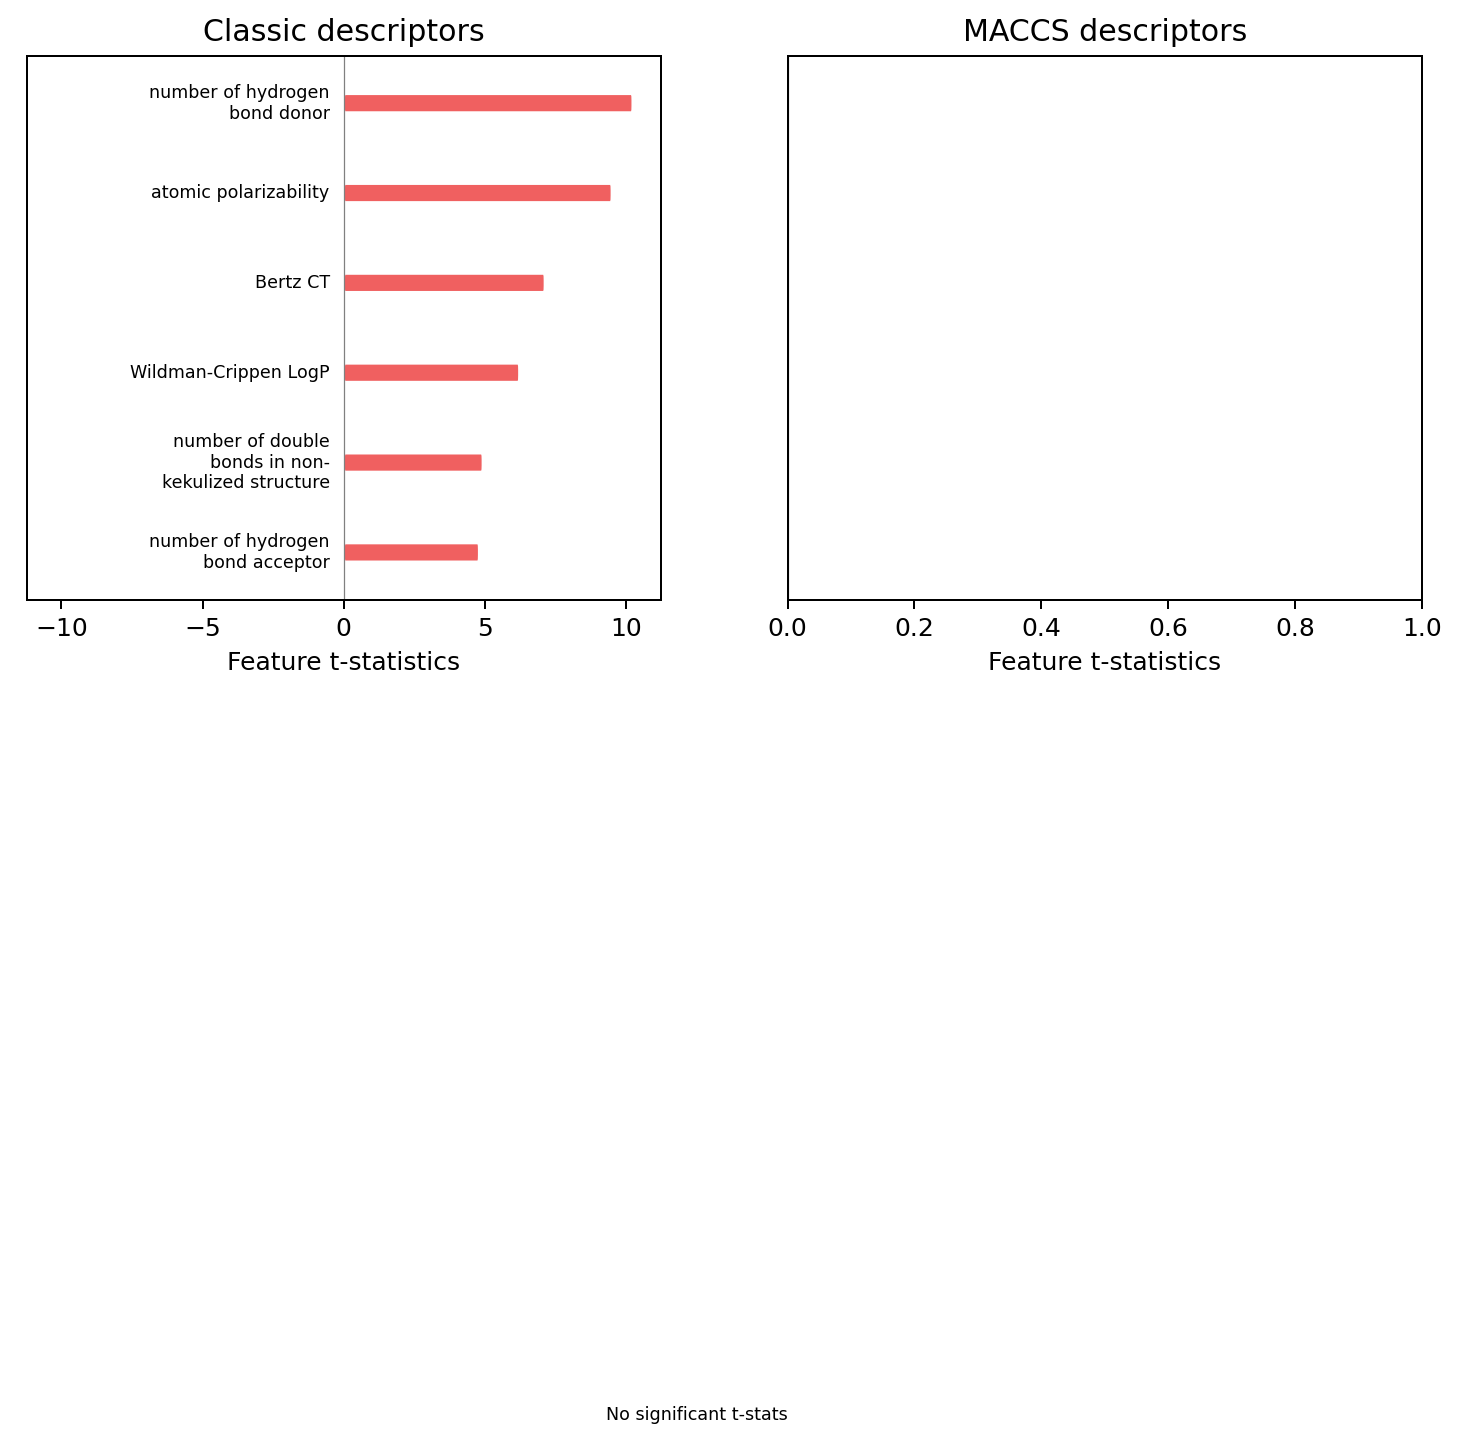

In [152]:
from mordred import HydrogenBond, Polarizability
from mordred import SLogP, AcidBase, BertzCT, Aromatic, BondCount
from mordred import Calculator
desc_type = ['Classic', 'MACCS']
fig, ax = plt.subplots(nrows=1, ncols=len(desc_type), figsize=(10,4), dpi=180, squeeze=True)
i=0
for d in desc_type:
    space_tstats, beta = exmol.lime_explain(space, descriptor_type=d)
    feature_importance = calc_ft_imp(space, space_tstats)
    if len(feature_importance.items()) > 5:
        feature_importance = {a:feature_importance[a] for a in list(feature_importance.keys())[:6]}
    plot_desc(feature_importance, d, output_file=None, 
                  ax=ax[i], title=f'{d} descriptors')
    # plot_with_desc(feature_importance, s, desc_type='classic', output_file=f'mutation_classic_{i}')
    i+=1
plt.savefig(f'desc_no_sig.png', dpi=180, bbox_inches='tight')
plt.show()

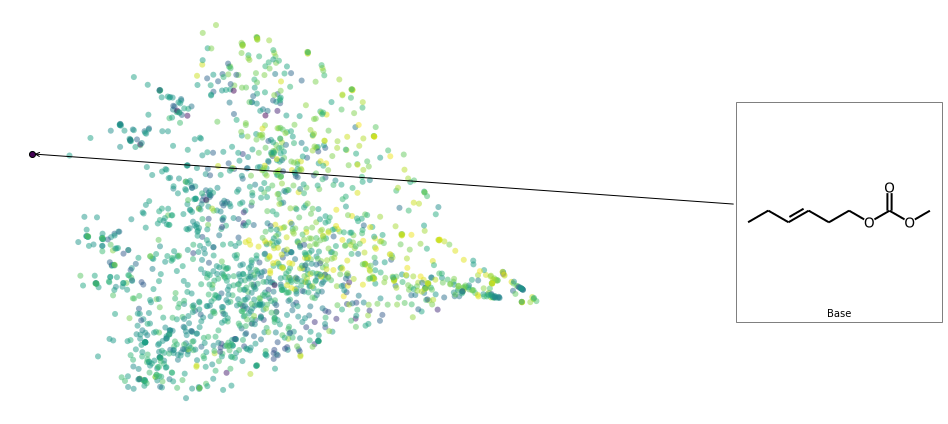

In [150]:
fkw = {'figsize': (8,6)}
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}
svg = exmol.plot_space(space, [space[0]], figure_kwargs=fkw, mol_size=(200,200), offset=1) #, ax=ax_dict['B']) #, cartoon=True)
# plt.colorbar(location='left', label='Solubility [Log M]')
plt.tight_layout()
plt.savefig('basic_2_no_sig.png', dpi=300, bbox_inches='tight')

In [14]:
def calc_ft_imp(space, space_tstats):
    from collections import OrderedDict
    feature_importance = {a:b for a, b in zip(space[0].descriptors.descriptor_names, space_tstats) if abs(b) > 2.96}
    feature_importance = dict(sorted(feature_importance.items(),
                 key=lambda item: abs(item[1]),
                 reverse=True))
    #Fitted space important features
    return feature_importance

In [29]:
from matplotlib.patches import Rectangle, FancyBboxPatch
import textwrap
def plot_with_desc(feature_importance, space, desc_type, output_file='file1.png'):
    font = {'family' : 'normal',
            'weight' : 'normal',
            'size'   : 12}

    fig = plt.figure(figsize=(12,5))
    # ax_dict = fig.subplot_mosaic('BBBAA')
    ax_dict = fig.subplot_mosaic('AAABBB')

    r = Rectangle((0, 0), 1, 1)
    # cmap = plt.get_cmap("gist_rainbow", 20)
    # colors = [mpl.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

    t = list(feature_importance.values())
    colors = []
    for ti in t:
        if ti < 0:
            colors.append(color_cycle[0])
        if ti > 0:
            colors.append(color_cycle[1])

    keys = list(feature_importance.keys())

    # bar1 = ax_dict['A'].barh(range(1,6), t, color=colors, height=0.5)
    bar1 = ax_dict['A'].barh(range(len(t)), t, color=colors, height=0.5)
    new_patches = []
    for patch in reversed(ax_dict['A'].patches):
        bb = patch.get_bbox()
        color=patch.get_facecolor()
        p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                            abs(bb.width), abs(bb.height),
                            boxstyle="round,pad=-0.040,rounding_size=0.015",
                            ec="none", fc=color,
                            mutation_aspect=4
                            )
        patch.remove()
        new_patches.append(p_bbox)
    for patch in new_patches:
        ax_dict['A'].add_patch(patch)

    count = 1
    for rect, ti, k in zip(bar1, t, keys):
        y = rect.get_y() + rect.get_height()/2.
        if len(k) > 60:
            k = textwrap.fill(k, 30)
        elif len(k) > 30:
            k = textwrap.fill(k, 25)
        if ti < 0:
            x = 0.5
            ax_dict['A'].text(x, y, k, ha='left', va='center', wrap=True)
            count+=1
        else:
            x = -1.0 #.5
            ax_dict['A'].text(x, y, k, ha='right', va='center', wrap=True)
            count+=1


    ax_dict['A'].axvline(x=0, color='grey', linewidth=0.5)
    ax_dict['A'].invert_yaxis()
    ax_dict['A'].set_xlabel('Feature t-statistics')
    # ax_dict['A'].get_yaxis().set_ticks([])
    svg = exmol.plot_space(space, [space[0]], figure_kwargs=fkw, mol_size=(200,200), offset=1, ax=ax_dict['B']) #, cartoon=True)
    # plt.colorbar(location='left', label='Solubility [Log M]')
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches="tight")
#     if desc_type=='MACCS':
#         plt.savefig('no_significance_maccs2.svg', dpi=300, bbox_inches='tight')
#     if desc_type=='Classic':
#         plt.savefig('no_significance_classic2.svg', dpi=300, bbox_inches='tight')

In [147]:
def plot_desc(feature_importance, desc_type, output_file, title=None, ax = None):
    t = list(feature_importance.values())
    colors = []
    for ti in t:
        if ti < 0:
            colors.append(color_cycle[0])
        if ti > 0:
            colors.append(color_cycle[1])

    keys = list(feature_importance.keys())

    if len(t) > 0: 
        bar1 = ax.barh(range(len(t)), t, color=colors, height=0.5)
        new_patches = []
        for patch in reversed(ax.patches):
            bb = patch.get_bbox()
            color=patch.get_facecolor()
            p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                                abs(bb.width), abs(bb.height),
                                boxstyle="round,pad=-0.040,rounding_size=0.015",
                                ec="none", fc=color,
                                mutation_aspect=4
                                )
            patch.remove()
            new_patches.append(p_bbox)
        for patch in new_patches:
            ax.add_patch(patch)

        count = 1
        for rect, ti, k in zip(bar1, t, keys):
            y = rect.get_y() + rect.get_height()/2.
            if len(k) > 60:
                k = textwrap.fill(k, 20)
            elif len(k) > 25:
                k = textwrap.fill(k, 20)
            if ti < 0:
                x = 0.5
                ax.text(x, y, k, ha='left', va='center', wrap=True, fontsize=7)
                count+=1
            else:
                x = -0.5
                ax.text(x, y, k, ha='right', va='center', wrap=True, fontsize=7)
                count+=1
            
        ax.set_xlim(-max(t)-1, max(t)+1)
    else:
        ax.text(0, 2.5, 'No significant t-stats', ha='right', va='center', wrap=True, fontsize=7)
    
    
    ax.axvline(x=0, color='grey', linewidth=0.5)
    ax.set_yticks([])
    ax.invert_yaxis()
    ax.set_xlabel('Feature t-statistics')
    ax.set_title(title)
    if output_file is not None:
        plt.savefig(output_file, dpi = 300, bbox_inches='tight')

In [62]:
exps = exmol.rcf_explain(space, 0.5, nmols=3)
exps = exmol.get_descriptors(exps)
# get tstats as a difference from base
for e in exps:
    if e.is_origin:
        base = e.descriptors.descriptors
        e.descriptors.tstats = np.subtract(base, e.descriptors.descriptors) * beta
    else:
        e.descriptors.tstats = np.subtract(base, e.descriptors.descriptors) * beta
        print(np.max(e.descriptors.tstats), np.min(e.descriptors.tstats))

on_bits = list(np.concatenate([[i for i in range(1,167) if e.descriptors.tstats[i] != 0]
                               for e in exps if e.is_origin==False]).flat)

TypeError: unsupported operand type(s) for *: 'int' and 'dict'

## Figure showing effect of mutation number and Alphabet


In [174]:
tstats, beta = {'Classic': [], 'MACCS': []}, {'Classic': [], 'MACCS': []}
spaces = {'Classic':[], 'MACCS': []}
desc_type = ['Classic', 'MACCS']
muts = [1,3,5]
for i in muts:
    for d in desc_type:
        stoned_kwargs={'num_samples': 2500, 'alphabet':exmol.get_basic_alphabet(),'min_mutations':i, 'max_mutations': i}
        space = exmol.sample_space(soldata.SMILES[100], predictor_function, stoned_kwargs=stoned_kwargs)
        t, b = exmol.lime_explain(space, descriptor_type=d)
        spaces[d].append(space)    
        tstats[d].append(t)
#         print(tstats)
        beta[d].append(b)
#         print(beta)

🤘Done🤘: 100%|██████████| 824.0/824 [00:00<00:00, 960.18it/s]                        
🤘Done🤘: 100%|██████████| 820.0/820 [00:00<00:00, 933.88it/s]                        
🤘Done🤘: 100%|██████████| 1790.0/1790 [00:03<00:00, 482.79it/s]                      
🤘Done🤘: 100%|██████████| 1821.0/1821 [00:04<00:00, 452.05it/s]                      
🤘Done🤘: 100%|██████████| 1857.0/1857 [00:03<00:00, 477.91it/s]                     
🤘Done🤘: 100%|██████████| 1824.0/1824 [00:03<00:00, 494.48it/s]                      


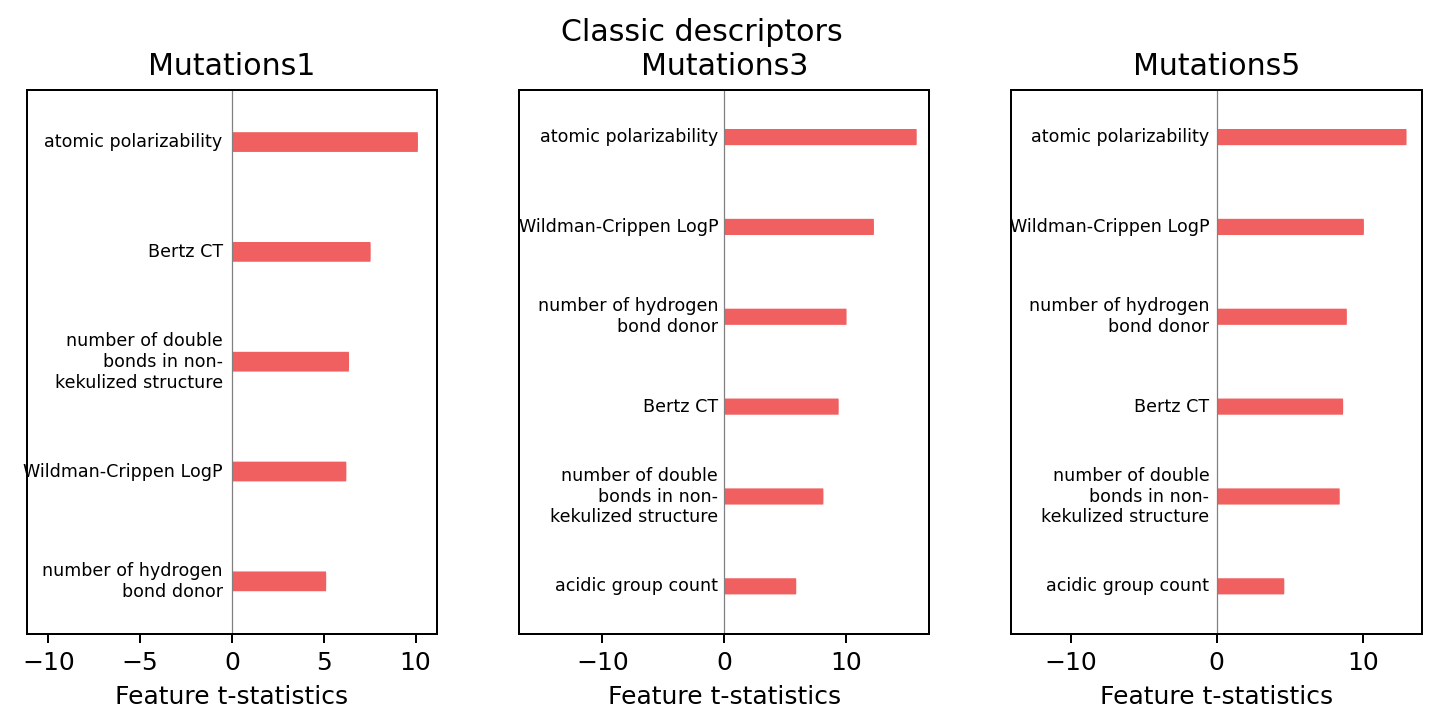

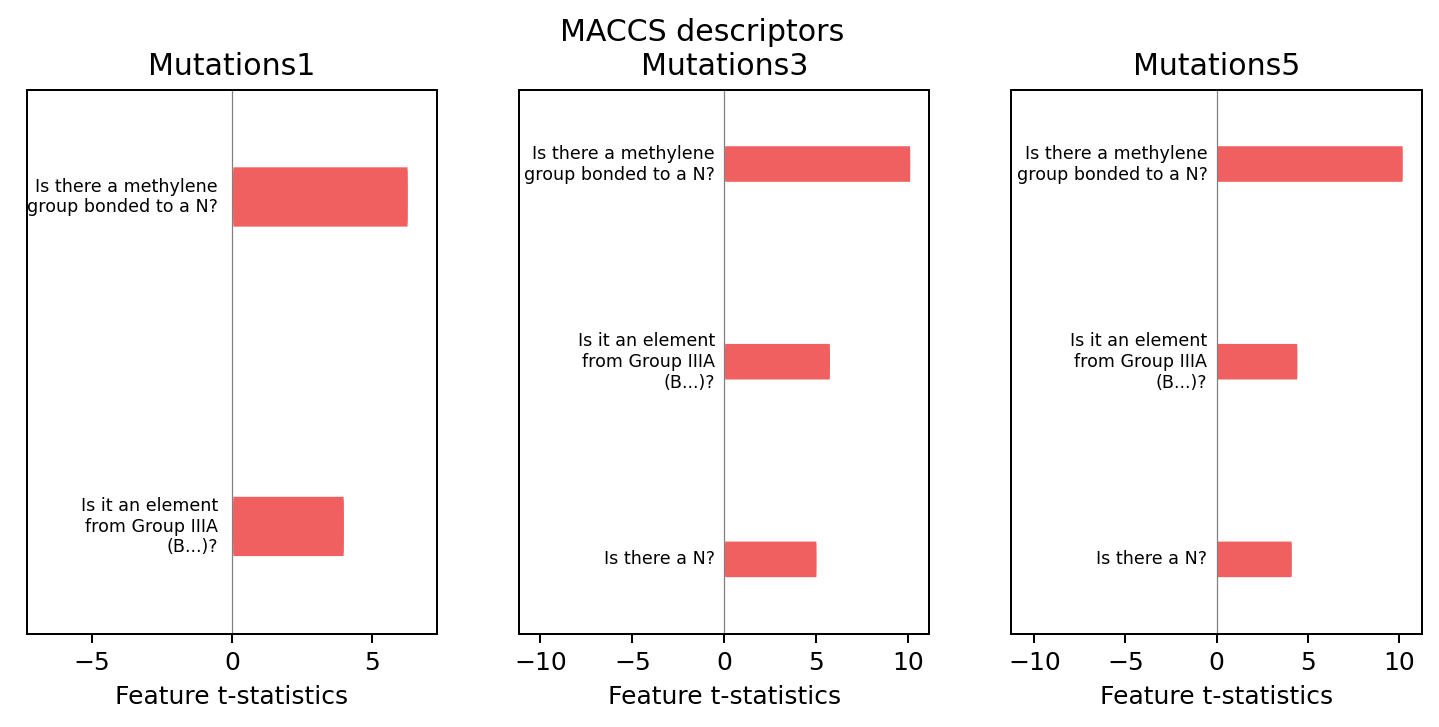

In [176]:

for d in desc_type:
    i = 0
    fig, ax = plt.subplots(nrows=1, ncols=len(tstats[d]), figsize=(10,4), dpi=180, squeeze=True)
    for s, t, b in zip(spaces[d], tstats[d], beta[d]):
        feature_importance = calc_ft_imp(s, t)
        plot_desc(feature_importance, d, output_file=None, 
                  ax=ax[i], title=f'Mutations{muts[i]}')
    # plot_with_desc(feature_importance, s, desc_type='classic', output_file=f'mutation_classic_{i}')
        i += 1
    fig.suptitle(f'{d} descriptors')
    plt.savefig(f'{d}_mutations.png', dpi=180, bbox_inches='tight')


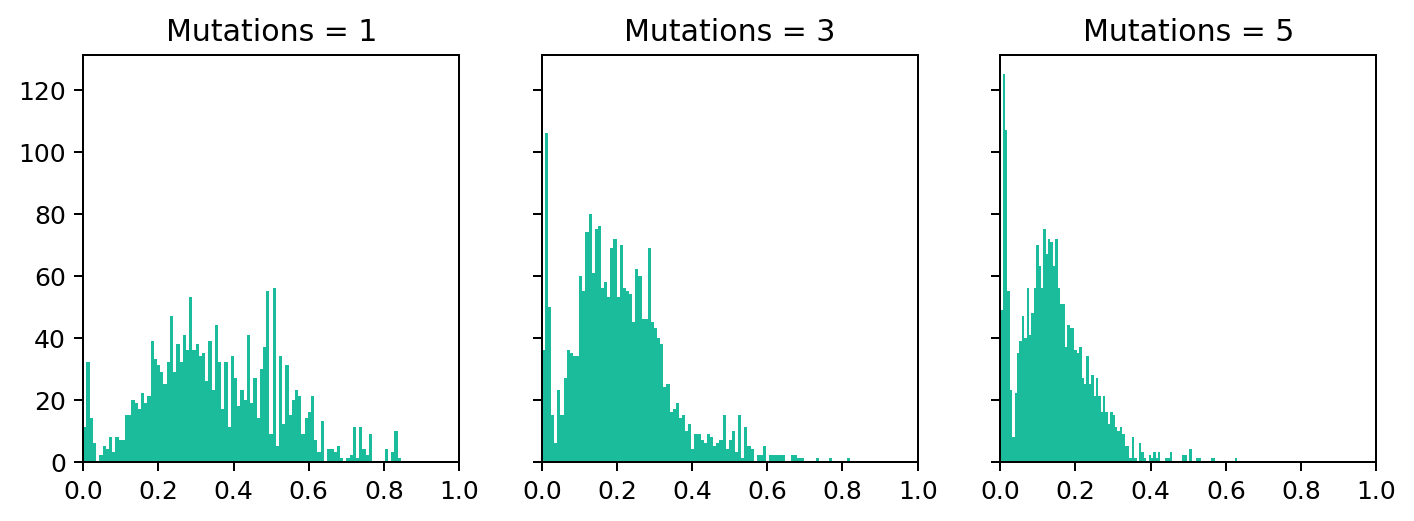

In [91]:
fig, axs = plt.subplots(1, 3, figsize=(8,3), dpi=180, squeeze=True, sharey=True)
for i,n in enumerate([1,3,5]):
    axs[i].hist([e.similarity for e in spaces[i][1:]], bins=99,edgecolor='none')
    axs[i].set_title(f'Mutations = {n}')
    axs[i].set_xlim(0,1)
plt.tight_layout()
plt.savefig('rnn-mutation-hist.png', bbox_inches='tight', dpi=180)

In [172]:
tstats, beta = {'Classic': [], 'MACCS': []}, {'Classic': [], 'MACCS': []}
spaces = {'Classic': [], 'MACCS': []}
basic = exmol.get_basic_alphabet()
train = sf.get_alphabet_from_selfies(selfies_list)
wide = sf.get_semantic_robust_alphabet()
desc_type = ['Classic', 'MACCS']
alphs = {'Basic': basic, 'Training Data': train, 'SELFIES': wide}

for a in alphs:
    for d in desc_type:
        stoned_kwargs={'num_samples': 2500, 'alphabet':alphs[a],'max_mutations':2}
        space = exmol.sample_space(soldata.SMILES[100], predictor_function, stoned_kwargs=stoned_kwargs)
        spaces[d].append(space)
        print(d)
        t, b = exmol.lime_explain(space, descriptor_type=d)
        tstats[d].append(t)
        beta[d].append(b)

🤘Done🤘: 100%|██████████| 2129.0/2129 [00:05<00:00, 393.50it/s]              

Classic



🤘Done🤘: 100%|██████████| 2060.0/2060 [00:05<00:00, 390.05it/s]              


MACCS


🤘Done🤘: 100%|██████████| 3197.0/3197 [00:13<00:00, 245.35it/s]              


Classic


🤘Done🤘: 100%|██████████| 3253.0/3253 [00:13<00:00, 244.28it/s]              


MACCS


🤘Done🤘: 100%|██████████| 2441.0/2441 [00:07<00:00, 328.59it/s]              

Classic



🤘Done🤘: 100%|██████████| 2486.0/2486 [00:07<00:00, 319.29it/s]              


MACCS


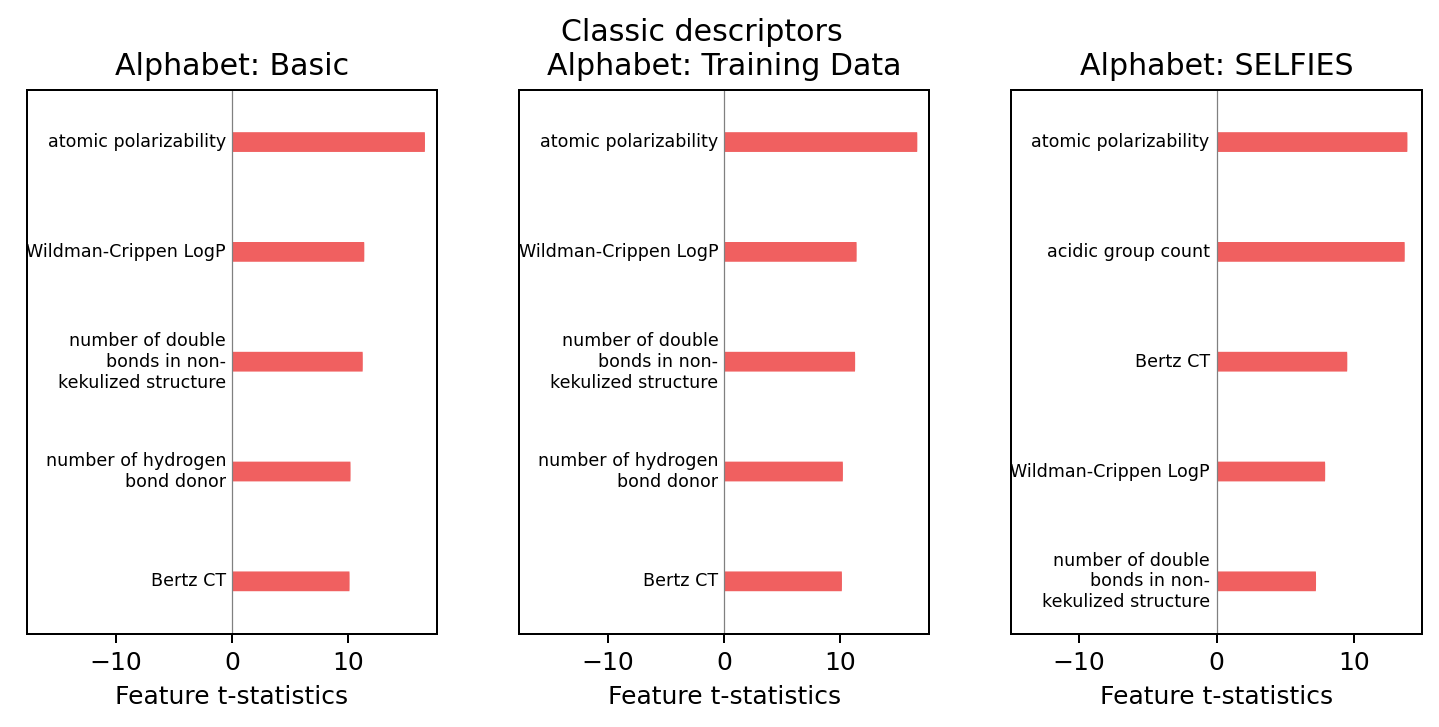

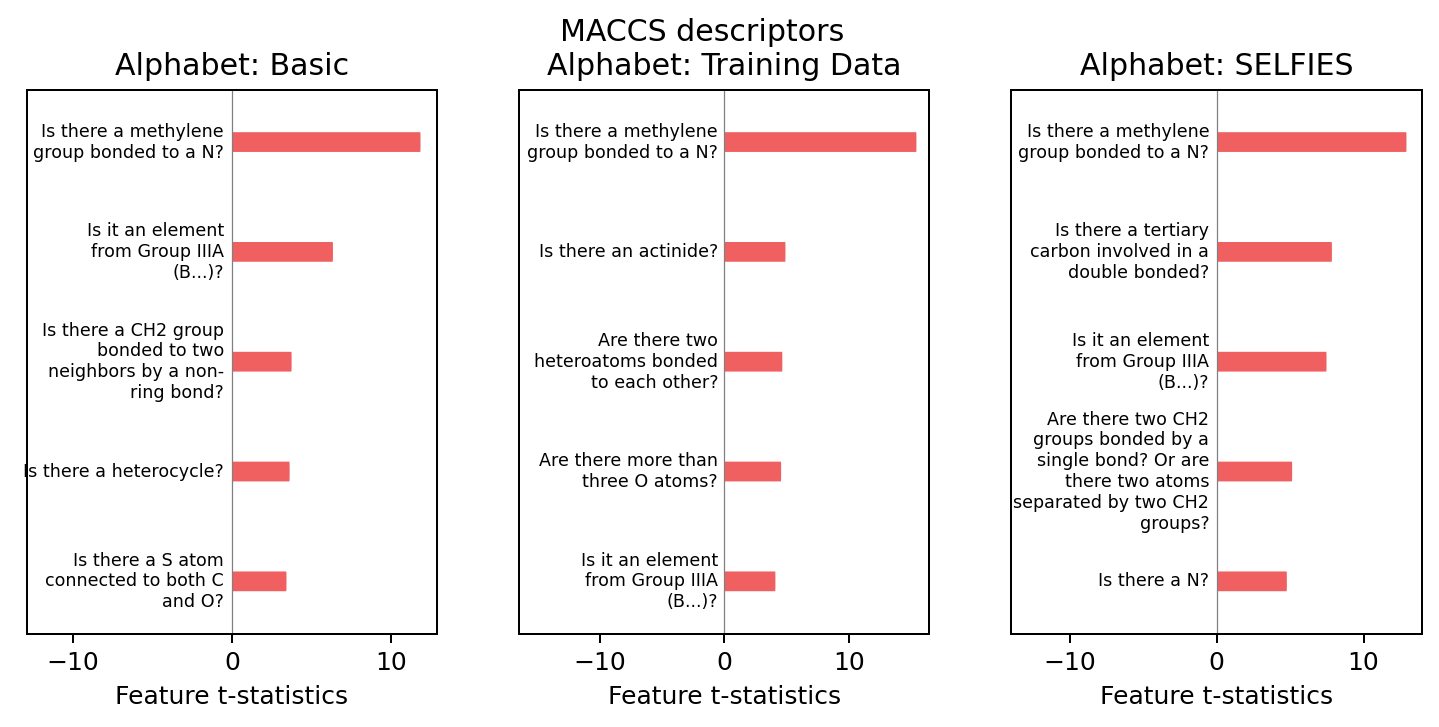

In [173]:
akeys = list(alphs.keys())

for d in desc_type:
    i = 0
    fig, ax = plt.subplots(nrows=1, ncols=len(tstats[d]), figsize=(10,4), dpi=180, squeeze=True)
    for s, t, b in zip(spaces[d], tstats[d], beta[d]):
        feature_importance = calc_ft_imp(s, t)
        if len(feature_importance.items()) > 5:
            feat = {a:feature_importance[a] for a in list(feature_importance.keys())[:5]}
        plot_desc(feat, d, output_file=None, 
                  ax=ax[i], title=f'Alphabet: {akeys[i]}')
    # plot_with_desc(feature_importance, s, desc_type='classic', output_file=f'mutation_classic_{i}')
        i += 1
    fig.suptitle(f'{d} descriptors')
    plt.savefig(f'{d}_alphabet.png', dpi=180, bbox_inches='tight')


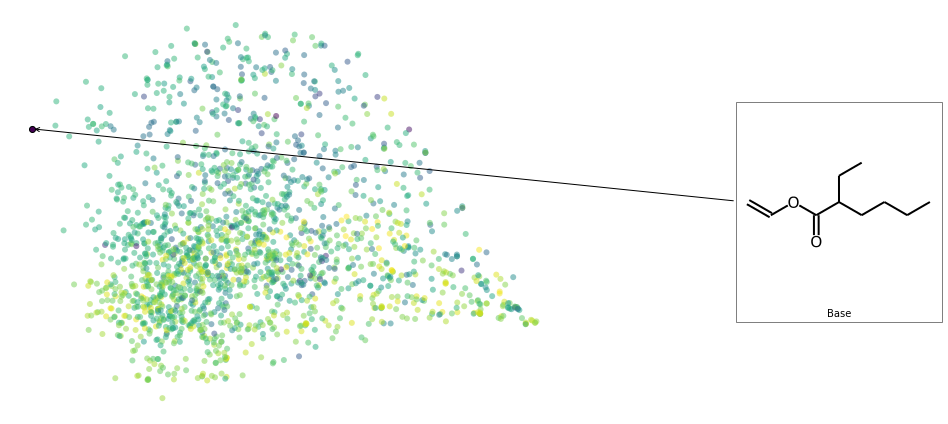

In [181]:
svg = exmol.plot_space(spaces[d][1], [spaces[d][1][0]], figure_kwargs=fkw, mol_size=(200,200), offset=1) #, ax=ax_dict['B']) #, cartoon=True)
# plt.colorbar(location='left', label='Solubility [Log M]')
plt.tight_layout()
plt.savefig('basic_2.png', dpi=300, bbox_inches='tight')

# soldata.SMILES[100]